In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import torch as torch
import os
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import pixiedust
from torchvision import transforms,datasets,models
from collections import OrderedDict

Pixiedust database opened successfully


In [2]:
DATA_DIRECTORY = "../datos/"

In [3]:
diagnosticos  = pd.read_excel(DATA_DIRECTORY+"RESUMEN TAC CEREBRALES.xlsx")

In [4]:
# diccionario cuya llave es el id de paciente y el valor una lista 
# donde cada elemento de la lista es la matriz de una i
diccionario_imagenes_pacientes = dict()

for paciente in diagnosticos.paciente:
    directorio_paciente = DATA_DIRECTORY+"paciente_"+str(paciente)
    archivos_paciente = os.listdir(directorio_paciente)
    
    lista_imagenes_paciente = []
    for archivo in archivos_paciente:
        if archivo.endswith(".jpg"):
            imagen = mpimg.imread(directorio_paciente+"/"+archivo)
            lista_imagenes_paciente.append(imagen)
            
    diccionario_imagenes_pacientes[paciente] = lista_imagenes_paciente
    

## Modelos y arquitecturas
### Arquitecturas experimental  DNC
* Alimentamos al modelo imagen por imagen y se presenta un solo diagnostico por paciente
* El controller de la DNC esta compuesto por una convnet

In [5]:
CONTROLLER_OUTPUT_SIZE = 128
READ_HEADS = 2

In [6]:
#TODO: cambiar valores quemados por valores parametrizados y calculos dependientes
class ConvController(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1,4,kernel_size=3,stride=1)
        self.fc1  =  torch.nn.Linear(262144,CONTROLLER_OUTPUT_SIZE)
        
        
    def forward(self,x):
        h = self.conv1(x)
        
        #flatten
        h =  x.view(-1,x.shape[1]*x.shape[2]*x.shape[3])
        h =  self.fc1(h)
        
        return h #h_t in my txt
    
class Controller(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv_controller = ConvController()
        self.fc1 = torch.nn.Linear(10,CONTROLLER_OUTPUT_SIZE)
        self.fc2 = torch.nn.Linear(2*CONTROLLER_OUTPUT_SIZE,CONTROLLER_OUTPUT_SIZE)
        
    def forward(self,x,read_vectors):
        h_conv = self.conv_controller(x)
        h_read_vectors = self.fc1(read_vectors)
        
        h_t = torch.cat((h_conv,h_read_vectors),dim=1)
        
        h_t =  torch.relu( h_t)
        h_t =  self.fc2(h_t) 
        
        return h_t

In [7]:

#TODO: cambiar valores quemados por valores parametrizados y calculos dependientes
#TODO: cordar por que en algun momento le puse bias = False a los pesos del vector de salida de la DNC


class DNC(torch.nn.Module):
    
    def __init__(self,controller,memory_size = (10,10),read_heads = 1,device="cpu"):
        super().__init__()
        self.controller = controller
        self.device = device
        self.N = memory_size[0] # number of memory locations
        self.W = memory_size[1] # word size of the memory 
        self.R = read_heads # number of read heads
        self.WS = 1 #not in the paper(they use 1), but used as a parametrizable number of write heads for further experiments
        self.interface_vector_size = (self.W*self.R) + (self.W*self.WS) + (2*self.W) + (5*self.R) + 3
        
        # inicialization st to random just for testing, remember to put on zeros
        #self.memory_matrix = self.memory_matrix =  nn.Parameter(torch.zeros(size=memory_size),requires_grad= False) 
        
        #1024 es el tamaño del vector de salida del controlador, 1 es el tamaño de salida de la dnc
        self.output_vector_linear = torch.nn.Linear(CONTROLLER_OUTPUT_SIZE,1,bias=True) #W_y 
        self.interface_vector_linear = torch.nn.Linear(CONTROLLER_OUTPUT_SIZE,self.interface_vector_size,bias=True) #W_ξ
        self.read_vectors_to_output_linear = torch.nn.Linear(self.R*self.W,1,bias = True) #W_r in my txt
        
        self.read_keys = torch.Tensor(size=(self.R,self.W)).requires_grad_(False) # k_r in my txt
        self.read_strenghts = torch.Tensor(size=(self.R,1)).requires_grad_(False) #β_r
        
        #self.read_weighting = torch.Tensor(torch.zeros(size=(self.R,self.N))).requires_grad_(False).to(device) #r_w
        
        self.write_key = torch.Tensor(size=(1,self.W)).requires_grad_(False) # k_w in my txt
        self.write_strenght = torch.Tensor(size=(1,1)).requires_grad_(False) # β_w
        
        #self.write_weighting = torch.Tensor(torch.zeros(size=(1,self.N))).requires_grad_(False) # w_w
        
        #self.usage_vector = torch.Tensor(torch.zeros(size=(1,self.N))).requires_grad_(False) #u_t
        
        self.memory_matrix_ones = torch.Tensor(torch.ones(size=memory_size)).requires_grad_(True).to(device) #E on paper
        
        self.reset()
        
    def forward(self,x,read_vectors):
        
        h_t = self.controller(x,read_vectors) #controller output called ht in the paper
        
        output_vector = self.output_vector_linear(h_t) # called Vt in the paper(υ=Wy[h1;...;hL]) v_o_t in my txt
        interface_vector = self.interface_vector_linear(h_t).data #called ξt(ksi) in the paper ,ξ_t in my txt
        
        self.read_keys.data = interface_vector[0,0:self.R*self.W].view((self.R,self.W)) #k_r in my txt
        
        #clamp temporary added because the exp was returning inf  values
        read_strenghts =  torch.clamp( interface_vector[0,self.R*self.W:self.R*self.W+self.R].view((self.R,1)),max=85)
        self.read_strenghts.data = self.oneplus(read_strenghts) #β_r
        
        self.write_key.data = interface_vector[0,self.R*self.W+self.R:self.R*self.W+self.R+self.W].view((1,self.W)) # k_w
        
        write_strenght = torch.clamp(interface_vector[:,self.R*self.W+self.R+self.W:self.R*self.W+self.R+self.W + 1].view((1,1)),max=85)
        self.write_strenght.data = self.oneplus(write_strenght) #β_w
        
        erase_vector = interface_vector[0,self.R*self.W+self.R+self.W + 1: self.R*self.W+self.R+self.W + 1 + self.W].view((1,self.W))
        erase_vector = torch.sigmoid(erase_vector) #e_t
        
        write_vector = interface_vector[0,self.R*self.W+self.R+self.W + 1 + self.W:self.R*self.W+self.R+self.W + 1 + 2*self.W].view((1,self.W)) #v_t
        
        free_gates  =  interface_vector[0,self.R*self.W+self.R+self.W + 1 + 2*self.W:self.R*self.W+2*self.R+self.W + 1 + 2*self.W].view((self.R,1)) #f_t
        free_gates =   torch.sigmoid(free_gates)
        
        allocation_gate = interface_vector[0,self.R*self.W+2*self.R+self.W + 1 + 2*self.W:self.R*self.W+2*self.R+self.W + 1 + 2*self.W+1]
        allocation_gate = torch.sigmoid(allocation_gate)
        
        write_gate = interface_vector[0,self.R*self.W+2*self.R+self.W + 1 + 2*self.W+1:self.R*self.W+2*self.R+self.W + 1 + 2*self.W+2]
        write_gate = torch.sigmoid( write_gate)
        
        
        # Escritura
        # TODO: verificar y/o experimentar si el ordern es :primero escribir y luego leer de la memoria(asi parece en el pazper)
        retention_vector = (1.0 - free_gates * self.read_weighting).prod(dim=0)
        self.usage_vector.data = (self.usage_vector +self.write_weighting - (self.usage_vector *self.write_weighting))*retention_vector #u_t
        allocation_weighting = self.calc_allocation_weighting(self.usage_vector)
        write_content_weighting = self.content_lookup(self.memory_matrix,self.write_key,self.write_strenght)

        self.write_weighting.data =  write_gate*(  
            (allocation_gate * allocation_weighting) +  ((1- allocation_gate)*write_content_weighting))
        
        new_memory_matrix = self.memory_matrix*(self.memory_matrix_ones - torch.matmul(self.write_weighting.t(),erase_vector)) + torch.matmul(self.write_weighting.t(),write_vector)
        
        self.memory_matrix.data = new_memory_matrix
        
        # read by content weithing(attention by similarity)
        read_content_weighting = self.content_lookup(self.memory_matrix,self.read_keys,self.read_strenghts)
        
        #read weithing is a combination of reading modes,TODO:add temporal attention not just by similarity
        self.read_weighting.data = read_content_weighting
        
        read_vectors = torch.matmul(self.read_weighting,self.memory_matrix).view((1,self.R*self.W)) #r in my txt
        read_heads_to_output = self.read_vectors_to_output_linear(read_vectors) #v_r_t in my t xt
        
        #TODO: experiment and decide if maintain sigmoid
        y_t = torch.sigmoid(output_vector + read_heads_to_output)
        return y_t,read_vectors
    
    def oneplus(self,x):
        # apply oneplus operation to a tensor to constrain it's elements to [1,inf)
        #TODO: check numerical statiliby as exp is returning inf for numbers like 710,emporary added clamp to 85
        return torch.log(1+torch.exp(x)) + 1
    
    def content_lookup(self,matrix,keys,strengths):
        # returns a probability distribution over the memory locations 
        # with higher probability to memory locations with bigger similarity to the keys
        # bigger strenght make more aggresive distributions ,for example a distribution (0.2,0.3,0.5) with
        # bigger strenght becomes (0.1,0.12,0.78)
        # returns tensor of shape (read keys,memory size) = (R,N)
        keys_norm =  torch.sqrt(torch.sum(keys**2,dim=1).unsqueeze(dim=1))
        matrix_norm = torch.sqrt(torch.sum(matrix**2,dim=1))
        norms_multiplication = keys_norm*matrix_norm
        # calc cosine similarity between keys and memory locations(1e-6 is used avoiding div by 0)
        divide_zero_prevent_factor = torch.zeros_like(norms_multiplication).add_(1e-6)
        cosine_similarity = torch.matmul(keys,matrix.t())/(torch.max(norms_multiplication,divide_zero_prevent_factor))
        
        # do a "strenght" softmax to calculate the probability distribution
        numerator = torch.exp(cosine_similarity*strengths)
        denominator = numerator.sum(dim=1).unsqueeze(dim=1)

        distribution = numerator/denominator
        
        return distribution
    
    def calc_allocation_weighting(self,usage_vector):
        #print("usage vector",usage_vector)
        _,free_list = torch.topk(-usage_vector,self.N,dim=1) #φt indices of memory locations ordered by usage
        #print("free list",free_list)
        free_list = free_list.view(-1)
        #print("reshaped free list",free_list)
        _,ordered_free_list =  torch.topk(-free_list,self.N)
        ordered_free_list = ordered_free_list.view(-1)
        #print("ordered free list",ordered_free_list)
        ordered_usage_vector = usage_vector[:,free_list]
        #print("ordered usage vector",ordered_usage_vector)
        ordered_usage_vector_cumulative_product = torch.ones(size=(1,self.N+1)).to(device)
        #print(ordered_usage_vector_cumulative_product)
        #print("cumprod ",ordered_usage_vector.cumprod(dim=1))
        ordered_usage_vector_cumulative_product[0,1:] = ordered_usage_vector.cumprod(dim=1)
        #print(ordered_usage_vector_cumulative_product)
        
        allocation_weighting = (1 - usage_vector)*ordered_usage_vector_cumulative_product[0,ordered_free_list]
        
        return  allocation_weighting
    
    def reset(self):
        self.memory_matrix =  torch.Tensor(torch.zeros(size=(self.N,self.W))).requires_grad_(True).to(device) 
        self.read_weighting = torch.Tensor(torch.zeros(size=(self.R,self.N))).requires_grad_(True).to(device) #r_w
        self.write_weighting = torch.Tensor(torch.zeros(size=(1,self.N))).requires_grad_(True).to(device) # w_w
        self.usage_vector = torch.Tensor(torch.zeros(size=(1,self.N))).requires_grad_(True).to(device) #u_t

## Experimentos
* Experimentando con DNC alimentando una imagen a la vez en orden aleatorio con pacientes también en orden aleatorio

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
EPOCHS = 50

In [10]:
conv_controller = Controller()
dnc_model = DNC(controller=conv_controller,memory_size = (5,5),read_heads=2,device=device).to(device)

In [11]:
base_criterion = torch.nn.BCELoss()
def loss_function(y,y_hat,last_flag):
    #print(y,y_hat,last_flag)
    #base_criterion = torch.nn.BCELoss()
    return torch.full_like(y,last_flag) * base_criterion(y,y_hat)
    #return base_criterion(y,y_hat)

In [12]:
criterion = loss_function
optimizer = optim.Adam(dnc_model.parameters(),lr=0.001)


total_accuracies  = []
for epoch in range(EPOCHS):
    epoch_predictions = []
    epoch_real_values = []
    # en cada epoch procesar los pacientes en orden aleatorio
    pacientes = np.random.choice(np.array(diagnosticos.paciente),size= len(diagnosticos.paciente),replace=False)
    
    conteo_pacientes = 0
    for paciente in pacientes:
        #TODO: remover esta validacion, solo puesta para probar una unica iteracion en compu lenta
        if conteo_pacientes >= 99999999:
            break
            
        dnc_model.reset()
        read_vectors = torch.zeros(size=(1,dnc_model.R*dnc_model.W)).to(device)
        
        imagenes_paciente = diccionario_imagenes_pacientes.get(paciente)
        diagnostico_hemorragia_paciente = np.array(float(diagnosticos[diagnosticos.paciente==paciente].hemorragia))
        tensor_diagnostico_hemorragia_paciente = torch.Tensor(diagnostico_hemorragia_paciente).to(device)
        
        indices_imagenes_pacientes = np.arange(0,len(imagenes_paciente)-1,step=1)
        indices_aleatorios_imagenes = np.random.choice(indices_imagenes_pacientes,len(indices_imagenes_pacientes),replace=False)
        
        losses = []
        for indice in indices_aleatorios_imagenes:
            last_image =  int(indice  == indices_aleatorios_imagenes[-1])
            
            #optimizer.zero_grad()
            
            imagen_paciente = imagenes_paciente[indice]
            
            if imagen_paciente.shape != (512,512):
                #TODO: tread different image sizes with reshaping, resizing(or other ideas)
                continue
                
            tensor_imagen_paciente =  torch.unsqueeze(
                torch.unsqueeze( torch.Tensor(imagen_paciente),dim=0),dim=1).to(device)
            
            #print("Alimentando paciente {} e imagen {} al modelo".format(paciente,indice),imagen_paciente.shape)
            
            diagnostico_hemorragia_aproximado,read_vectors = dnc_model(tensor_imagen_paciente,read_vectors)
            loss = criterion(diagnostico_hemorragia_aproximado,tensor_diagnostico_hemorragia_paciente,last_image)
            
            losses.append(loss.view((1,1)))
            
            if last_image:
                y_hat = diagnostico_hemorragia_aproximado.data.cpu().numpy()[0][0]
                y_hat_hard = float(y_hat >= 0.5)
                epoch_predictions.append(y_hat_hard)
                epoch_real_values.append(float(diagnostico_hemorragia_paciente))
                
                #print("--Flag ultima imagen:{} diagnostico:{} valor real{}".format(last_image,y_hat,diagnostico_hemorragia_paciente))
                optimizer.zero_grad()
                
                patient_loss = torch.cat(losses).sum()
                
                patient_loss.backward()
                optimizer.step()

                
        conteo_pacientes += 1
            
    epoch_predictions = np.array(epoch_predictions)
    epoch_real_values = np.array(epoch_real_values)
    correct_predictions = epoch_predictions == epoch_real_values
    accuracy = np.average(correct_predictions)
    total_accuracies.append(accuracy)
    print("Epoch {}: accuracy {}".format(epoch,accuracy),epoch_predictions,epoch_real_values)

print(np.average(total_accuracies))

In [13]:
#TODO: averiguar por que salen 6 tensores de parametros si solo se han declarado 3(al momento de correr lap rueba)
train_parmams = list(dnc_model.named_parameters())

for train_param in train_parmams:
    print(train_param[0])

controller.conv_controller.conv1.weight
controller.conv_controller.conv1.bias
controller.conv_controller.fc1.weight
controller.conv_controller.fc1.bias
controller.fc1.weight
controller.fc1.bias
controller.fc2.weight
controller.fc2.bias
output_vector_linear.weight
output_vector_linear.bias
interface_vector_linear.weight
interface_vector_linear.bias
read_vectors_to_output_linear.weight
read_vectors_to_output_linear.bias


In [14]:
dnc_model.memory_matrix.data


tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0')

Meta (por detallar))
* L temporal link matrix

In [15]:
###

### LSTM con conv
* Experimentando con lstm alimentando una imagen a la vez en orden aleatorio con pacientes también en orden aleatorio

El vector de entrada de la lstm es un vector producido por una convnet

In [16]:
CONVNET_OUTPUT_SIZE = 64
CONVNET_HIDDEN_SIZE = 64

LSTM_HIDDEN_SIZE = 64

FINAL_LAYER_SIZE = 64

In [17]:
architecture = 'densenet121'
architecture_constructor = getattr(models,architecture)
model  =  architecture_constructor(pretrained=True)
features_size = list(model.children())[-1].in_features
#model

/home/luis/anaconda2/envs/pytorch_challenge/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [18]:

#freeze parameters so we don't backpropagete  through them

for parameter in model.parameters():
    parameter.requires_grad = False

In [19]:
model_classifier = torch.nn.Sequential(OrderedDict([
    ("fc1",torch.nn.Linear(features_size,CONVNET_HIDDEN_SIZE)),
    ("relu",torch.nn.ReLU()),
    ("fc2",torch.nn.Linear(CONVNET_HIDDEN_SIZE,CONVNET_OUTPUT_SIZE))
]))

model.classifier = model_classifier

In [20]:
class ConvLSTM(nn.Module):
    
    def __init__(self,conv_net,lstm_layers=1):
        super().__init__()
        self.conv_net = conv_net
        self.lstm = nn.LSTM(input_size= CONVNET_OUTPUT_SIZE,hidden_size = LSTM_HIDDEN_SIZE,num_layers=lstm_layers,batch_first = True)
        self.lstm_layers = lstm_layers
        
        self.output_linear = nn.Linear(LSTM_HIDDEN_SIZE,1)
    
    def forward(self,x,hidden):
        x = self.conv_net(x)
        x = x.unsqueeze(0)
        x,hidden = self.lstm(x,hidden)
        x = torch.sigmoid(self.output_linear(x))
        
        return x,hidden
    
    def init_hidden(self):
        weigths =  next(self.lstm.parameters())
        
        
        hidden = ( 
            weigths.new(self.lstm_layers,1,LSTM_HIDDEN_SIZE).to(device)
        ,   weigths.new(self.lstm_layers,1,LSTM_HIDDEN_SIZE).to(device)
                 )
        
        return hidden

In [21]:
train_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor()
    
])



In [22]:
conv_lstm = ConvLSTM(model,lstm_layers=2)
conv_lstm.to(device)

base_criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-5)

In [23]:
EPOCHS = 100

In [24]:

total_accuracies  = []
total_losses = []

for epoch in range(EPOCHS):
    
    
    epoch_predictions = []
    epoch_real_values = []
    epoch_losses = []
    # en cada epoch procesar los pacientes en orden aleatorio
    pacientes = np.random.choice(np.array(diagnosticos.paciente),size= len(diagnosticos.paciente),replace=False)
    
    conteo_pacientes = 0
    for paciente in pacientes:
        #TODO: remover esta validacion, solo puesta para probar una unica iteracion en compu lenta
        if conteo_pacientes >= 99999999:
            break
        h = conv_lstm.init_hidden()
        
        conv_lstm.zero_grad()
        imagenes_paciente = diccionario_imagenes_pacientes.get(paciente)
        diagnostico_hemorragia_paciente = np.array(float(diagnosticos[diagnosticos.paciente==paciente].hemorragia))
        tensor_diagnostico_hemorragia_paciente = torch.Tensor(diagnostico_hemorragia_paciente).view((1,1)).to(device)
        
        indices_imagenes_pacientes = np.arange(0,len(imagenes_paciente)-1,step=1)
        indices_aleatorios_imagenes = np.random.choice(indices_imagenes_pacientes,len(indices_imagenes_pacientes),replace=False)
        
        losses = []
        for indice in indices_aleatorios_imagenes:
            h = tuple([each.data for each in h])
            last_image =  int(indice  == indices_aleatorios_imagenes[-1])
            
            #optimizer.zero_grad()
            
            imagen_paciente =  np.expand_dims(imagenes_paciente[indice],2)
            imagen_paciente =  np.repeat(imagen_paciente,3,axis=2)
               
            tensor_imagen_paciente =  train_data_transforms(imagen_paciente).unsqueeze(0).to(device)
            
            
            #print("Alimentando paciente {} e imagen {} al modelo".format(paciente,indice),imagen_paciente.shape)
            
            diagnostico_hemorragia_aproximado,h  = conv_lstm(tensor_imagen_paciente,h)
            
            
            loss = base_criterion(diagnostico_hemorragia_aproximado,tensor_diagnostico_hemorragia_paciente)
            
            losses.append(loss.view((1,1)))
            
            if last_image:
                y_hat = diagnostico_hemorragia_aproximado.data.cpu().numpy()[0][0]
                y_hat_hard = float(y_hat >= 0.5)
                epoch_predictions.append(y_hat_hard)
                epoch_real_values.append(float(diagnostico_hemorragia_paciente))
                
                #print("--Flag ultima imagen:{} diagnostico:{} valor real{}".format(last_image,y_hat,diagnostico_hemorragia_paciente))
                optimizer.zero_grad()
                
                patient_loss = torch.cat(losses).mean()
                
                
                patient_loss.backward()
                nn.utils.clip_grad_norm_(conv_lstm.lstm.parameters(), 5.0)
                optimizer.step()
                
                epoch_losses.append(patient_loss.data.cpu().numpy())

                
        conteo_pacientes += 1
        
            
    epoch_predictions = np.array(epoch_predictions)
    epoch_real_values = np.array(epoch_real_values)
    correct_predictions = epoch_predictions == epoch_real_values
    accuracy = np.average(correct_predictions)
    epoch_avg_loss = np.average(epoch_losses)
    total_losses.append(epoch_avg_loss)
    
    total_accuracies.append(accuracy)
    print("Epoch {}: accuracy {} loss:{}".format(epoch,accuracy,epoch_avg_loss))

#print(np.average(total_accuracies))
print(total_losses)
print(total_accuracies)

/home/luis/anaconda2/envs/pytorch_challenge/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 0: accuracy 0.2 loss:0.7011079788208008
Epoch 1: accuracy 0.6 loss:0.6926363706588745
Epoch 2: accuracy 0.6 loss:0.6922743916511536
Epoch 3: accuracy 0.6 loss:0.6916260123252869
Epoch 4: accuracy 0.6 loss:0.6875404119491577
Epoch 5: accuracy 0.6 loss:0.6784027814865112
Epoch 6: accuracy 0.6 loss:0.6836014986038208
Epoch 7: accuracy 0.6 loss:0.6842354536056519
Epoch 8: accuracy 0.6 loss:0.6793322563171387
Epoch 9: accuracy 0.6 loss:0.684627890586853
Epoch 10: accuracy 0.6 loss:0.6757789850234985
Epoch 11: accuracy 0.6 loss:0.6834770441055298
Epoch 12: accuracy 0.6 loss:0.6782934665679932
Epoch 13: accuracy 0.6 loss:0.6799529790878296
Epoch 14: accuracy 0.6 loss:0.6796591877937317
Epoch 15: accuracy 0.6 loss:0.6791219711303711
Epoch 16: accuracy 0.6 loss:0.6748263239860535
Epoch 17: accuracy 0.6 loss:0.6754723787307739
Epoch 18: accuracy 0.6 loss:0.6726205945014954
Epoch 19: accuracy 0.6 loss:0.6785569787025452
Epoch 20: accuracy 0.6 loss:0.6661025285720825
Epoch 21: accuracy 0.6 l

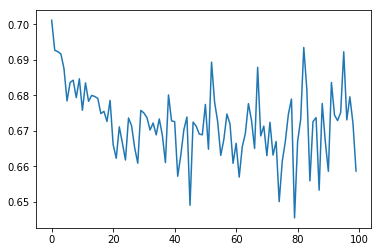

In [25]:
plt.plot(total_losses)
plt.show()

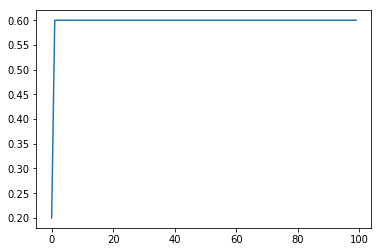

In [26]:
plt.plot(total_accuracies)
plt.show()

## Ideas
* Normalizar  el allocation weighitng con sofmax(en la primera iteración asigna todo el peso a la primera posición de memoria)
* Usar arquitectura similar a dueling network o inception para tener 2 caminos en las entradas.
* Cambiar el modelo original para leer antes que escribir y usar lo leido para sacar una predicción en ese punto en el tiempo(el modelo original lee de la memoria despues de escribir y usa la info leida en el siguiente paso)